# Model - 3 (ResNet)
This model is a ResNet Model for the task of automatic verification of offline signatures.

In [ ]:
from tensorflow.keras.layers import Activation, Add, AvgPool2D, BatchNormalization, Conv2D, Dense, Flatten, Input, MaxPool2D, ZeroPadding2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.initializers import random_uniform, glorot_uniform, constant
from tensorflow.keras.utils import plot_model
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau

from h5py import File
import matplotlib.pyplot as plt
import numpy as np
from numpy.random import permutation, randint, rand
from numpy import rint
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import tensorflow as tf

from numpy import expand_dims
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from keras.preprocessing.image import ImageDataGenerator
from tensorflow import keras
from tensorflow import one_hot, reshape
from keras.layers import BatchNormalization
import cv2

# from keras.models import Sequential
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras import Sequential
from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras.utils import plot_model

In [ ]:
def identity_block(X, f, filters, training=True, initializer=random_uniform, activation='relu', seed=0):
    F1, F2, F3 = filters
    Y = X

    Y = Conv2D(filters=F1, kernel_size=1, strides=1, padding='valid', kernel_initializer=initializer(seed=seed)) (Y)
    Y = BatchNormalization() (Y, training=training)
    Y = Activation(activation = activation) (Y)

    Y = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_initializer=initializer(seed=seed)) (Y)
    Y = BatchNormalization() (Y, training=training)
    Y = Activation(activation = activation) (Y)

    Y = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=initializer(seed=seed)) (Y)
    Y = BatchNormalization() (Y, training=training)

    Y = Add() ([Y, X])
    Y = Activation(activation = activation) (Y)

    return Y

In [ ]:
def convolutional_block(X, f, filters, s=2, training=True, initializer=glorot_uniform, activation='relu', seed=0):
    F1, F2, F3 = filters
    Y = X

    Y = Conv2D(filters=F1, kernel_size=1, strides=s, padding='valid', kernel_initializer=initializer(seed=seed)) (Y)
    Y = BatchNormalization() (Y, training=training)
    Y = Activation(activation = activation) (Y)

    Y = Conv2D(filters=F2, kernel_size=f, strides=1, padding='same', kernel_initializer=initializer(seed=seed)) (Y)
    Y = BatchNormalization() (Y, training=training)
    Y = Activation(activation = activation) (Y)

    Y = Conv2D(filters=F3, kernel_size=1, strides=1, padding='valid', kernel_initializer=initializer(seed=seed)) (Y)
    Y = BatchNormalization() (Y, training=training)

    X = Conv2D(filters=F3, kernel_size=1, strides=s, padding='valid', kernel_initializer=initializer(seed=seed)) (X)
    X = BatchNormalization() (X, training=training)

    Y = Add() ([Y, X])
    Y = Activation(activation = activation) (Y)

    return Y

In [ ]:
def  ResNet50(input_shape = (512, 512, 3), classes = 2, activation='relu', seed=0):
    Y = Input(input_shape)
    X = Y
    X = ZeroPadding2D(3)(X)

    X = Conv2D(filters=64, kernel_size = 7, strides = 2, kernel_initializer = glorot_uniform(seed=seed)) (X)
    X = BatchNormalization() (X)
    X = Activation(activation=activation) (X)
    X = MaxPool2D((3, 3), strides=(2, 2)) (X)

    X = convolutional_block(X, f = 3, filters = [64, 64, 256], s = 1, seed=seed)
    X = identity_block(X, 3, [64, 64, 256], seed=seed)
    X = identity_block(X, 3, [64, 64, 256], seed=seed)

    X = convolutional_block(X, f = 3, filters = [128, 128, 512], s = 2, seed=seed)
    X = identity_block(X, 3, [128, 128, 512], seed=seed)
    X = identity_block(X, 3, [128, 128, 512], seed=seed)
    X = identity_block(X, 3, [128, 128, 512], seed=seed)

    X = convolutional_block(X, f = 3, filters = [256, 256, 1024], s = 2, seed=seed)
    X = identity_block(X, 3, [256, 256, 1024], seed=seed)
    X = identity_block(X, 3, [256, 256, 1024], seed=seed)
    X = identity_block(X, 3, [256, 256, 1024], seed=seed)
    X = identity_block(X, 3, [256, 256, 1024], seed=seed)
    X = identity_block(X, 3, [256, 256, 1024], seed=seed)

    X = convolutional_block(X, f = 3, filters = [512, 512, 2048], s = 2, seed=seed)
    X = identity_block(X, 3, [512, 512, 2048], seed=seed)
    X = identity_block(X, 3, [512, 512, 2048], seed=seed)

    X = AvgPool2D(pool_size=(2, 2))(X)
    X = Flatten()(X)
    X = Dense(classes, activation='softmax', kernel_initializer = glorot_uniform(seed=seed))(X)

    model = Model(inputs = Y, outputs = X)
    return model

In [ ]:
plot_model(ResNet50(input_shape=(64, 128, 3)), show_shapes=True)

In [ ]:
from h5py import File
from matplotlib import pyplot
import numpy as np
import os
from tensorflow import one_hot, reshape

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
# database = input('Database Name: ')
# database = database.lower() + '_128x64.h5'
# file = os.path.join(os.getcwd(), 'database', database)
file = "/content/drive/MyDrive/bhsig260hindi_128x643.h5"
print(file)
try:
    with File(file, 'r') as hdf:
        X = np.array(hdf.get('X'))
        Y = np.array(hdf.get('Y'))
except Exception as ex:
    template = "An exception of type {0} occurred. Arguments:\n{1!r}"
    message = template.format(type(ex).__name__, ex.args)
    print(message)
X = X / 255.0
Y = Y * 1.0
# Y = one_hot(Y * 1.0, depth=2)
# Y = reshape(Y, (-1, 2))
print("Feature shape =", X.shape)
print("Label shape =", Y.shape)

/content/drive/MyDrive/bhsig260hindi_128x643.h5
Feature shape = (8640, 64, 128, 3)
Label shape = (8640, 1)


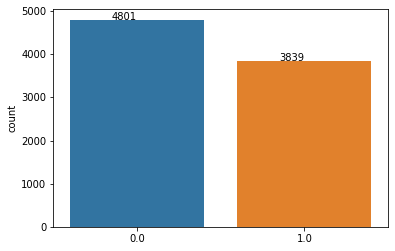

In [ ]:
ax = sns.countplot(x = Y.reshape(Y.shape[0]))
for p in ax.patches:
   ax.annotate('{:}'.format(p.get_height()), (p.get_x()+0.25, p.get_height()+0.01))

In [ ]:
import sklearn
class_weights = sklearn.utils.class_weight.compute_class_weight(class_weight = "balanced",classes = np.unique(Y),y = Y.reshape(Y.shape[0]))
class_weight_dict = dict(enumerate(class_weights))
class_weight_dict

{0: 0.8998125390543636, 1: 1.1252930450638188}

In [ ]:
seed=randint(10)
# metadata['split_seed']=seed
print('seed =', seed)
indices = permutation(X.shape[0])
# print(X)
same = True
if same:
    m = int(0.70 * X.shape[0])
    n = int(0.15 * X.shape[0])
    training_id, validation_id, test_id = indices[:m], indices[m: m + n], indices[m+n:]
    X_train, X_test, X_validate = X[training_id], X[test_id], X[validation_id]
    Y_train, Y_test, Y_validate = Y[training_id], Y[test_id], Y[validation_id]
else:
    m = int(0.70 * X.shape[0])
    training_id, validation_id = indices[:m], indices[m:]
    X_train, X_validate = X[training_id], X[validation_id]
    Y_train, Y_validate = Y[training_id], Y[validation_id]
print("Shape of Features in training set =", X_train.shape)
print("Shape of Labels in training set =", Y_train.shape)

del Y,X

seed = 2
Shape of Features in training set = (6048, 64, 128, 3)
Shape of Labels in training set = (6048, 1)


In [ ]:
#One hot Encoding
Y_train = one_hot(Y_train, depth=2)
Y_train = reshape(Y_train, (-1, 2))

Y_test = one_hot(Y_test, depth=2)
Y_test = reshape(Y_test, (-1, 2))

Y_validate = one_hot(Y_validate, depth=2)
Y_validate = reshape(Y_validate, (-1, 2))

In [ ]:
print("Shape of Labels in training set =", Y_train.shape)

Shape of Labels in training set = (6048, 2)


In [ ]:
with tf.device('/device:GPU:0'):
  model = ResNet50(input_shape=(64, 128, 3))
  SGD = tf.keras.optimizers.SGD(learning_rate = 1e-02,momentum = 0.9)
  model.compile(optimizer = SGD, loss='binary_crossentropy', metrics=['accuracy'])

## Model Training for 10 epochs

Optimizer - Adam (default hyperparameter)

Epochs - 10

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(X_train, Y_train, epochs = 20, batch_size = 32, validation_data=(X_validate, Y_validate),shuffle=True
                    ,class_weight = class_weight_dict)
print('training done')

In [ ]:
import pickle
folder = "/content/drive/MyDrive/ResNetEPOCHS10/"

In [ ]:
with open(folder  + 'trainHistoryDict', 'wb') as file_pi:
       pickle.dump(history, file_pi)
model.save(folder + 'model.h5')

In [ ]:
history = pickle.load(open(folder + 'trainHistoryDict', "rb"))
model = tf.keras.models.load_model(folder + 'model.h5')

## Model Training for 100 epochs


Optimizer - SGD (lr = 0.01)

Epochs - 100 (Early Stopping)

In [ ]:
import pickle
folder = "/content/drive/MyDrive/ResNetEPOCHS100/"

In [ ]:
with tf.device('/device:GPU:0'):
  callbacks = [
    EarlyStopping(patience = 5, verbose = 1),
    ModelCheckpoint(folder + 'model-{epoch:03d}.h5'
    , verbose=1,save_best_only = True)
]

In [ ]:
with tf.device('/device:GPU:0'):
  history = model.fit(X_train, Y_train, epochs = 100, batch_size = 32, validation_data=(X_validate, Y_validate),shuffle=True
                    ,class_weight = class_weight_dict,callbacks = callbacks)
print('training done')

Epoch 1/100
189/189 [==============================] - ETA: 0s - loss: 1.6307 - accuracy: 0.5577
Epoch 1: val_loss improved from inf to 0.83957, saving model to /content/drive/MyDrive/ResNetEPOCHS100/model-001.h5
189/189 [==============================] - 22s 93ms/step - loss: 1.6307 - accuracy: 0.5577 - val_loss: 0.8396 - val_accuracy: 0.6188
Epoch 2/100
189/189 [==============================] - ETA: 0s - loss: 0.8441 - accuracy: 0.6293
Epoch 2: val_loss did not improve from 0.83957
189/189 [==============================] - 15s 81ms/step - loss: 0.8441 - accuracy: 0.6293 - val_loss: 1.0157 - val_accuracy: 0.5818
Epoch 3/100
189/189 [==============================] - ETA: 0s - loss: 0.6793 - accuracy: 0.6609
Epoch 3: val_loss improved from 0.83957 to 0.60916, saving model to /content/drive/MyDrive/ResNetEPOCHS100/model-003.h5
189/189 [==============================] - 17s 92ms/step - loss: 0.6793 - accuracy: 0.6609 - val_loss: 0.6092 - val_accuracy: 0.6914
Epoch 4/100
189/189 [======

In [ ]:
# with open(folder  + 'trainHistoryDict', 'wb') as file_pi:
#        pickle.dump(history, file_pi)
# model.save(folder + 'BestModel.h5')

In [ ]:
history = pickle.load(open(folder + 'trainHistoryDict', "rb"))
# model = tf.keras.models.load_model(folder + 'BestModel.h5')

## Plotting

Optimizer - Adam (default hyperparameter)

Epochs - 10

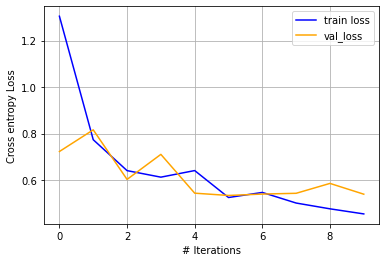

In [ ]:
plt.xlabel('# Iterations')
plt.ylabel('Cross entropy Loss')
plt.plot(history.history['loss'], color='blue',label = "train loss")
plt.plot(history.history['val_loss'], color='orange',label = "val_loss")
plt.legend()
plt.grid()
plt.savefig(folder + "loss.jpeg")
plt.show()

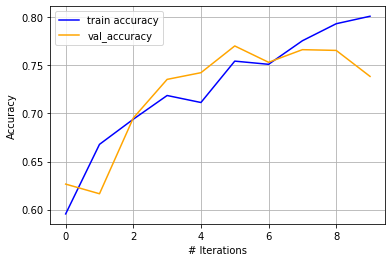

In [ ]:
plt.xlabel('# Iterations')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], color='blue',label = "train accuracy")
plt.plot(history.history['val_accuracy'], color='orange',label = "val_accuracy")
plt.grid()
plt.legend()
plt.savefig(folder + "accuracy.jpeg")
plt.show()

41/41 [==============================] - 2s 27ms/step


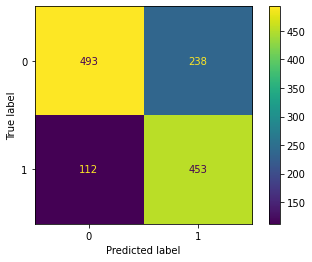

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(Y_test,axis = 1), tf.argmax(model.predict(X_test),axis = 1))).plot()
plt.savefig( folder + "confusionmatrix.jpeg")
plt.show()

41/41 [==============================] - 1s 25ms/step


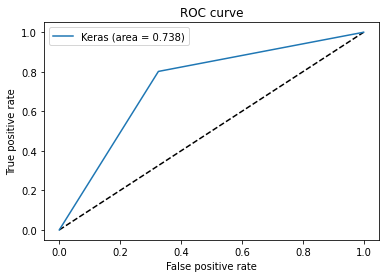

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
y_pred_keras = tf.argmax(model.predict(X_test),axis = 1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(tf.argmax(Y_test,axis = 1), y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(folder + "roc.jpeg")
plt.show()

## Plotting

Optimizer - SGD (lr = 0.01)

Epochs - 100 (Early Stopping)

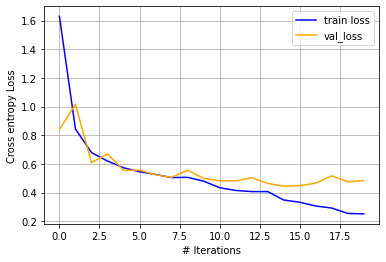

In [ ]:
plt.xlabel('# Iterations')
plt.ylabel('Cross entropy Loss')
plt.plot(history.history['loss'], color='blue',label = "train loss")
plt.plot(history.history['val_loss'], color='orange',label = "val_loss")
plt.legend()
plt.grid()
plt.savefig(folder + "loss.jpeg")
plt.show()

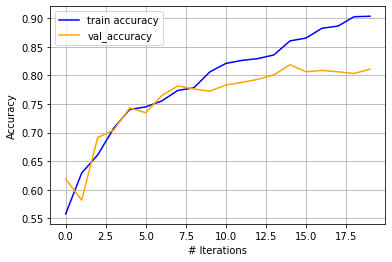

In [ ]:
plt.xlabel('# Iterations')
plt.ylabel('Accuracy')
plt.plot(history.history['accuracy'], color='blue',label = "train accuracy")
plt.plot(history.history['val_accuracy'], color='orange',label = "val_accuracy")
plt.grid()
plt.legend()
plt.savefig(folder + "accuracy.jpeg")
plt.show()

41/41 [==============================] - 2s 27ms/step


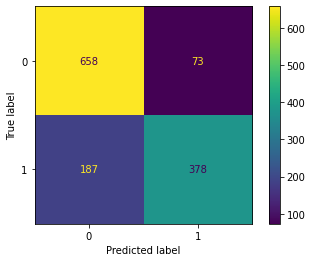

In [ ]:
ConfusionMatrixDisplay(confusion_matrix(tf.argmax(Y_test,axis = 1), tf.argmax(model.predict(X_test),axis = 1))).plot()
plt.savefig( folder + "confusionmatrix.jpeg")
plt.show()

41/41 [==============================] - 1s 25ms/step


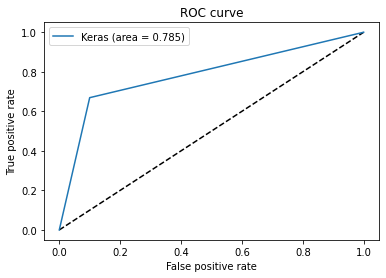

In [ ]:
from sklearn.metrics import auc
from sklearn.metrics import roc_curve
y_pred_keras = tf.argmax(model.predict(X_test),axis = 1)
fpr_keras, tpr_keras, thresholds_keras = roc_curve(tf.argmax(Y_test,axis = 1), y_pred_keras)
auc_keras = auc(fpr_keras, tpr_keras)
plt.figure(1)
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr_keras, tpr_keras, label='Keras (area = {:.3f})'.format(auc_keras))
# plt.plot(fpr_rf, tpr_rf, label='RF (area = {:.3f})'.format(auc_rf))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.savefig(folder + "roc.jpeg")
plt.show()